In [60]:
import arviz as az
import pandas as pd
import pymc as pm
from matplotlib import rcParams

rcParams['figure.figsize'] = [12, 8]
rcParams['figure.dpi'] = 200

In [17]:
df = pd.read_csv('data/h1weekly.csv',
                 parse_dates=['Date'],
                 index_col='Date',
                 dtype={'IsCanceled': float})
df.index.freq = 'W-SUN'

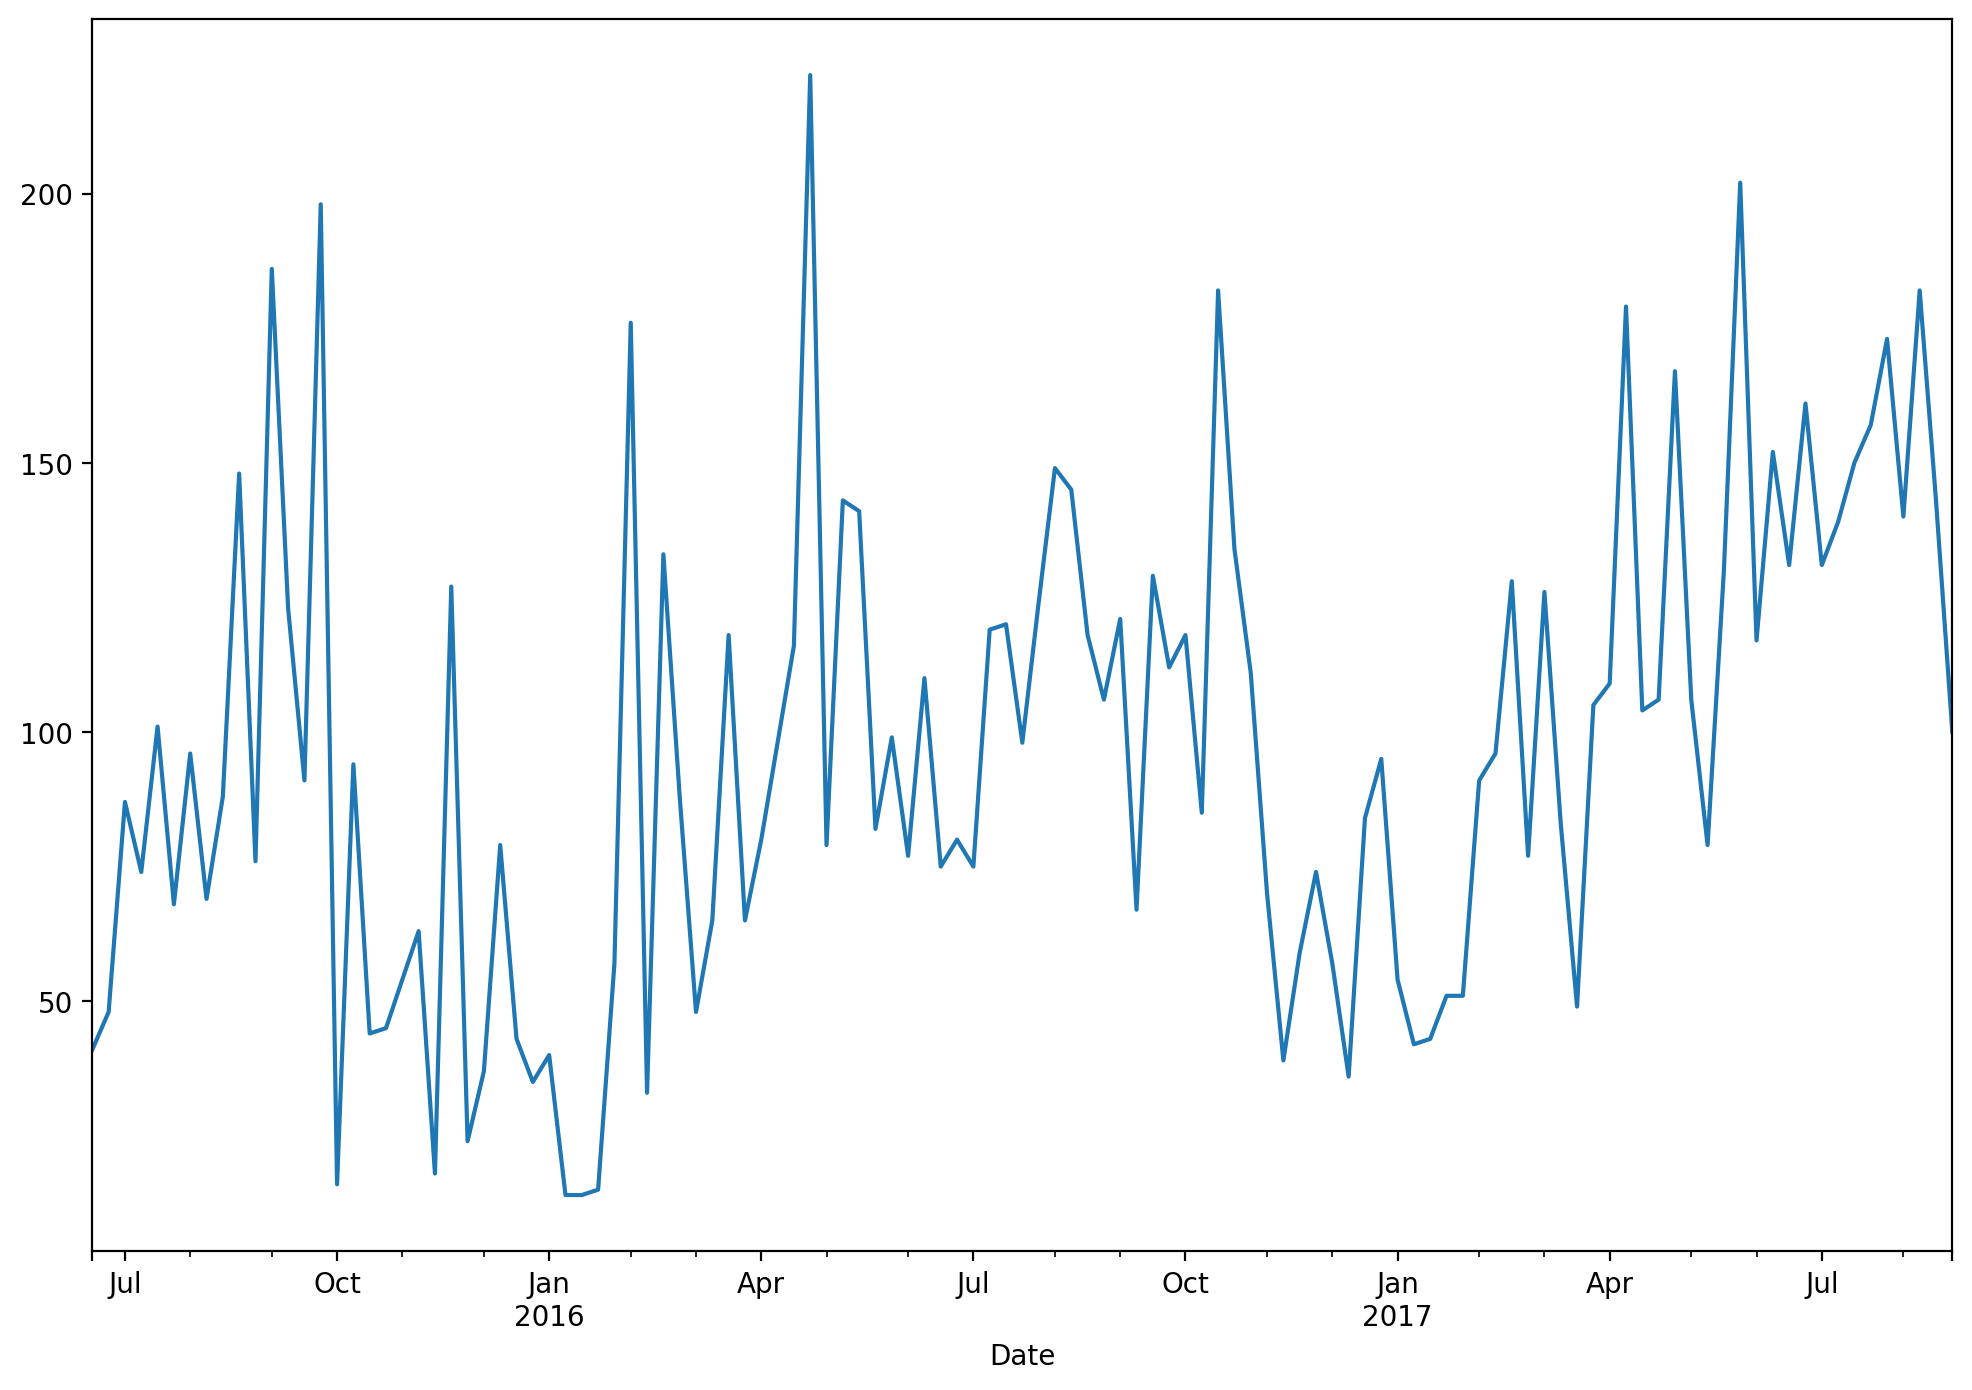

In [19]:
series = pd.Series(df['IsCanceled'])

_ = series.plot()

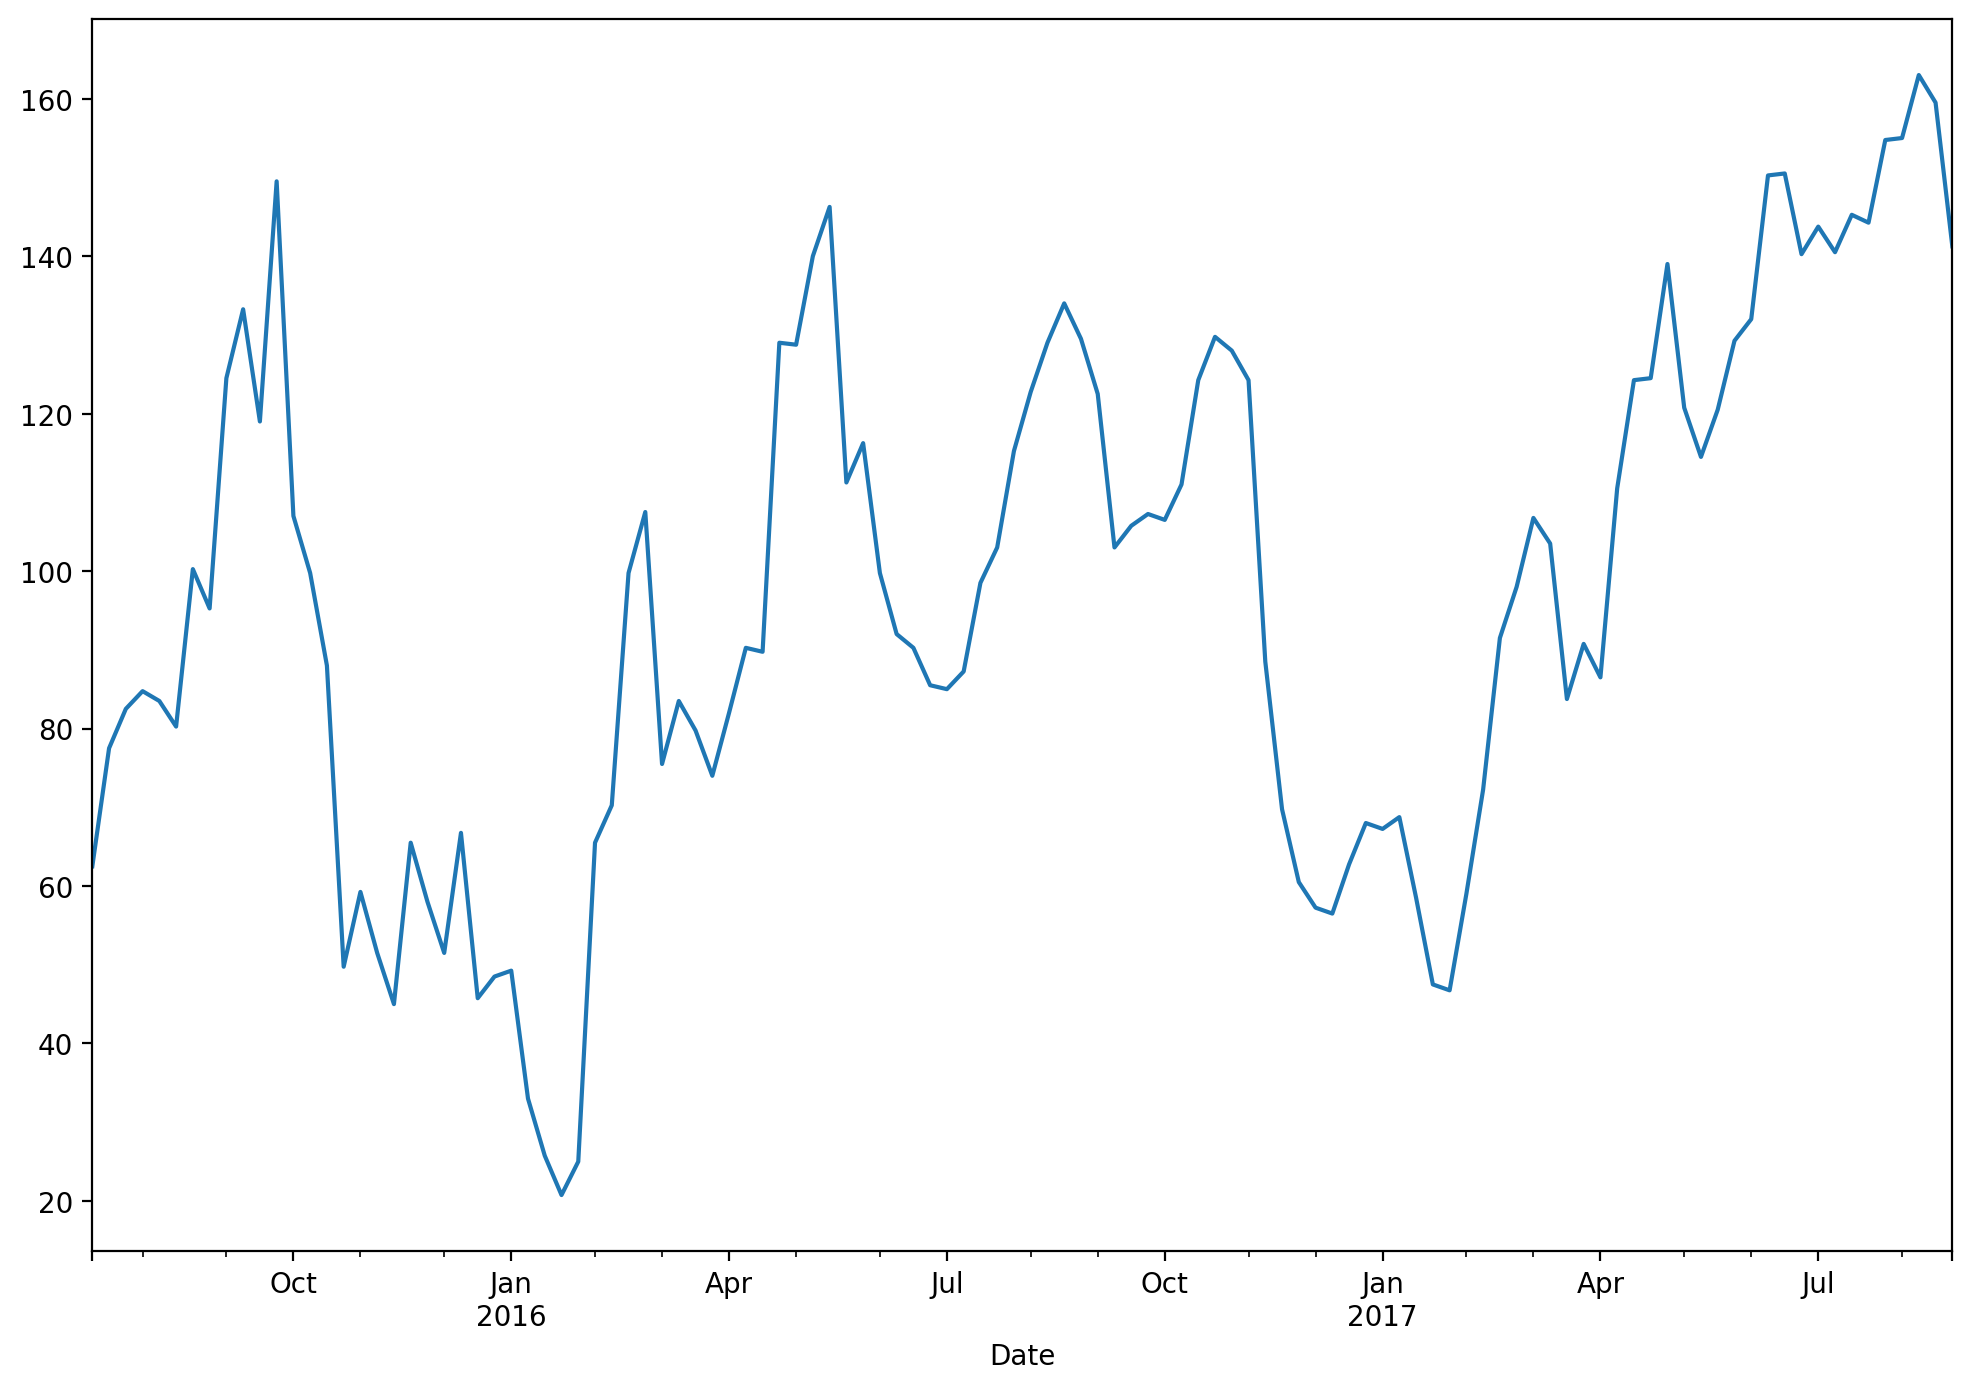

In [51]:
window_size = 4

windows = series.rolling(window_size)
series_smoothed = windows.mean().dropna()

_ = series_smoothed.plot()

In [70]:
with pm.Model() as model:
    rho = pm.Uniform('rho', -2, 2, size=3)
    init = pm.Uniform.dist(lower=0, upper=200, size=4)
    obs = pm.AR('obs', rho=rho, init_dist=init, observed=series_smoothed.values)
    trace = pm.sample(5000, tune=50000, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [rho]
<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 50_000 tune and 5_000 draw iterations (100_000 + 10_000 draws total) took 73 seconds.


In [71]:
# Generate posterior predictive samples
pp_samples = pm.sample_posterior_predictive(trace, model=model, var_names=['obs'])

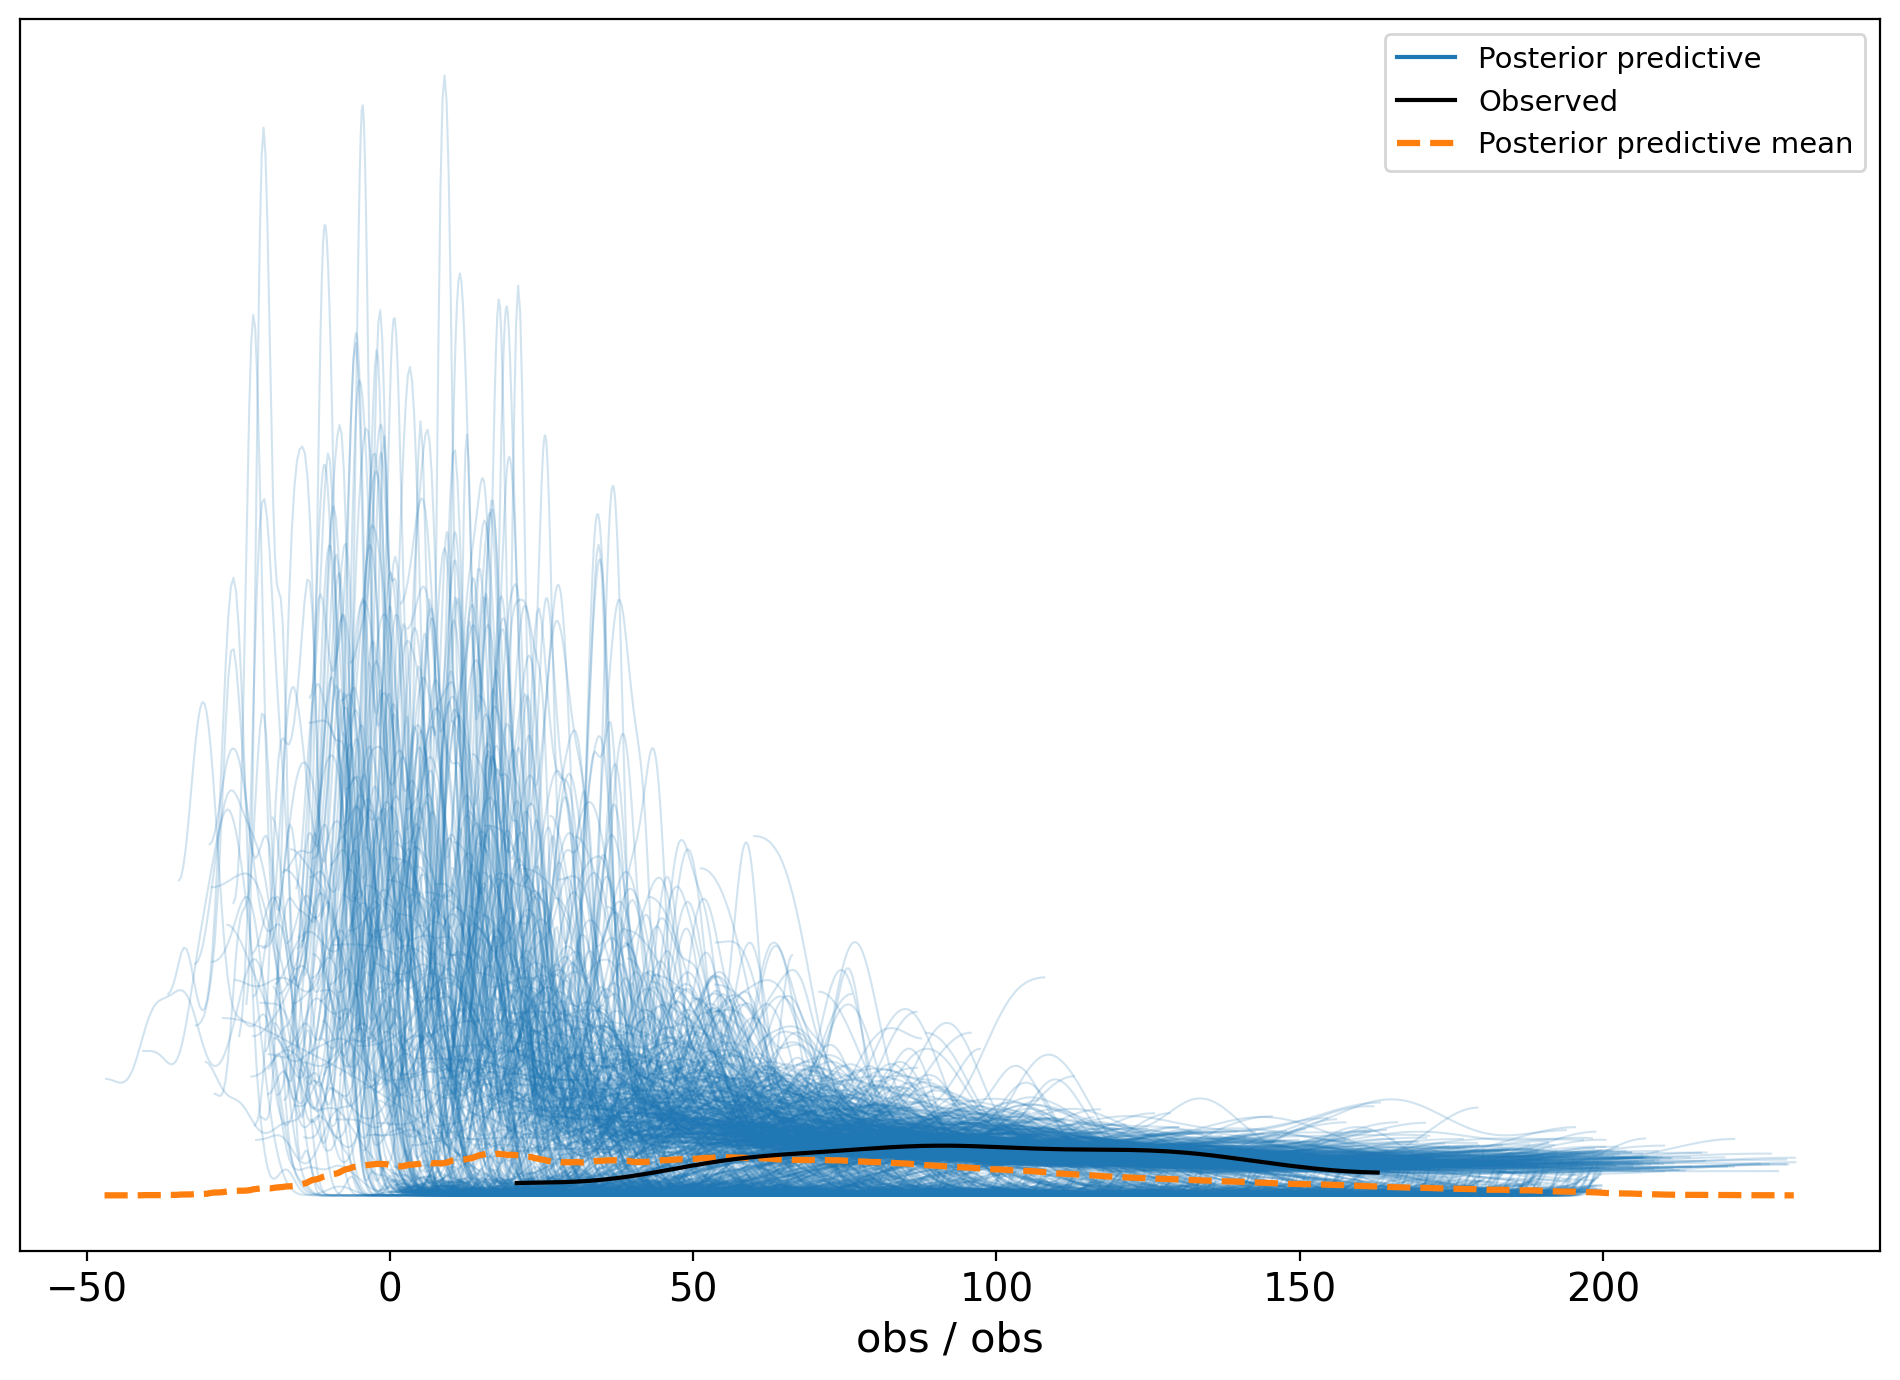

In [72]:
_ = az.plot_ppc(pp_samples, num_pp_samples=1000)